## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

# list the available physical GPU devices TensorFlow can detect on the machine
tf.config.list_physical_devices('GPU')

[]

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)

# samples with a size of 32x32 pixels and 3 color channels (RGB)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 51s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [8]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape, x_train[444].dtype 

((32, 32, 3), dtype('uint8'))

[9] truck


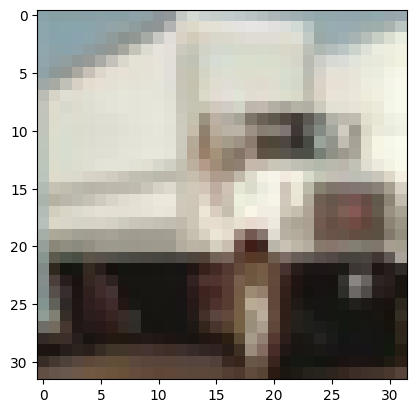

In [9]:
## Let's look at one of the images

image_no = 444
print(y_train[image_no], class_names[y_train[image_no][0]])
plt.imshow(x_train[image_no]);

In [10]:
num_classes = 10

'''
    ### one hot encoding 
    converting categorical labels into a binary matrix representation, 
    where each row corresponds to a sample, and each column corresponds to a class. 
    The column corresponding to the true class for a sample is set to 1, 
    and all other columns are set to 0.
'''

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [12]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# scale the data to lie between 0 and 1
x_train /= 255 
x_test /= 255

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
1. Below we will build our first CNN. For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  
2. We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  
3. After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [13]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 512)               147968    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                      

We still have 181K parameters, even though this is a "small" model.


In [14]:
batch_size = 32

# initiate RMSprop optimizer
# RMSprop, an optimizer that's usually a good choice for recurrent NN
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
# categorical_crossentropy, the loss function used for categorical classification
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10


1563/1563 [==============================] - 8s 5ms/step - loss: 1.6138 - accuracy: 0.4202 - val_loss: 1.4812 - val_accuracy: 0.4752
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2921 - accuracy: 0.5379 - val_loss: 1.2483 - val_accuracy: 0.5471
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1520 - accuracy: 0.5944 - val_loss: 1.1402 - val_accuracy: 0.5915
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0509 - accuracy: 0.6317 - val_loss: 1.1317 - val_accuracy: 0.6018
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9737 - accuracy: 0.6599 - val_loss: 1.0923 - val_accuracy: 0.6215
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9033 - accuracy: 0.6838 - val_loss: 1.0493 - val_accuracy: 0.6366
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8436 - accuracy: 0.7059 - val_loss: 1.0338 - val_accurac

In [15]:
print(history_1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [16]:
print("The loss on the test set is: ", model_1.evaluate(x_test, y_test)[0])
for i in range(len(history_1.history['loss'])):
    print("%d, %f\n" % (i+1, history_1.history['loss'][i]), end=' ')

313/313 [==============================] - 1s 2ms/step - loss: 1.0216 - accuracy: 0.6628
The loss on the test set is:  1.0215667486190796
1, 1.613767
 2, 1.292104
 3, 1.151970
 4, 1.050860
 5, 0.973706
 6, 0.903335
 7, 0.843643
 8, 0.786506
 9, 0.734284
 10, 0.687836
 

In [17]:
print("The accuracy on the test set is: ", model_1.evaluate(x_test, y_test)[1])
for i in range(len(history_1.history['accuracy'])):
    print("%d, %f\n" % (i+1, history_1.history['accuracy'][i]), end=' ')

313/313 [==============================] - 1s 2ms/step - loss: 1.0216 - accuracy: 0.6628
The accuracy on the test set is:  0.6628000140190125
1, 0.420220
 2, 0.537900
 3, 0.594400
 4, 0.631740
 5, 0.659860
 6, 0.683780
 7, 0.705860
 8, 0.727140
 9, 0.745940
 10, 0.759220
 

In [18]:
for i in range(len(history_1.history['val_loss'])):
    print("%d, %f\n" % (i+1, history_1.history['val_loss'][i]), end=' ')

1, 1.481201
 2, 1.248333
 3, 1.140153
 4, 1.131717
 5, 1.092345
 6, 1.049319
 7, 1.033796
 8, 1.061393
 9, 0.996213
 10, 1.021567
 

In [19]:
for i in range(len(history_1.history['val_accuracy'])):
    print("%d, %f\n" % (i+1, history_1.history['val_accuracy'][i]), end=' ')

1, 0.475200
 2, 0.547100
 3, 0.591500
 4, 0.601800
 5, 0.621500
 6, 0.636600
 7, 0.644100
 8, 0.639600
 9, 0.659900
 10, 0.662800
 

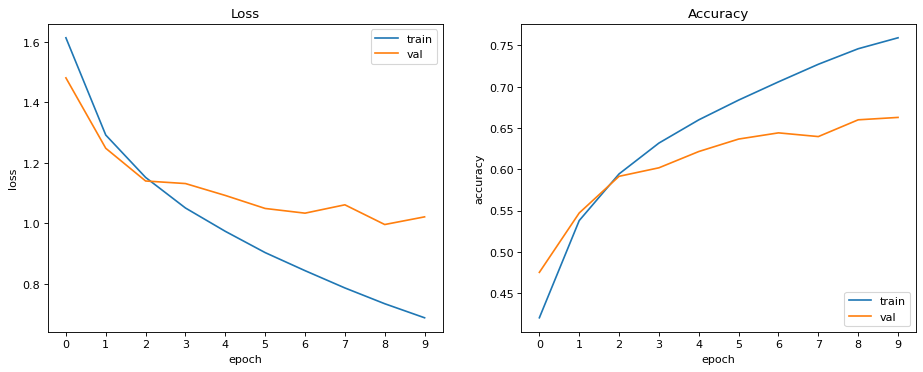

In [20]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

### Model Evaluation

In [21]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 0.634042, Accuracy: 0.781480
 Test Loss: 1.021567, Accuracy: 0.662800

[[803  35  77  30  37  29  20  34 180  73]
 [ 40 846  21  22  12   9  19  12  72 173]
 [ 38   7 585  97  93  71  57  42  15  16]
 [  8   4  55 445  50 201  49  36  16  14]
 [ 20   2 108  86 640  58  37  73  10   8]
 [  0   0  43 141  31 511  34  51   6   9]
 [ 14   9  58  83  48  35 760  13   6  10]
 [  7   4  31  46  72  64   9 722  10  23]
 [ 39  16  10  24  11  10   7   2 665  23]
 [ 31  77  12  26   6  12   8  15  20 651]]


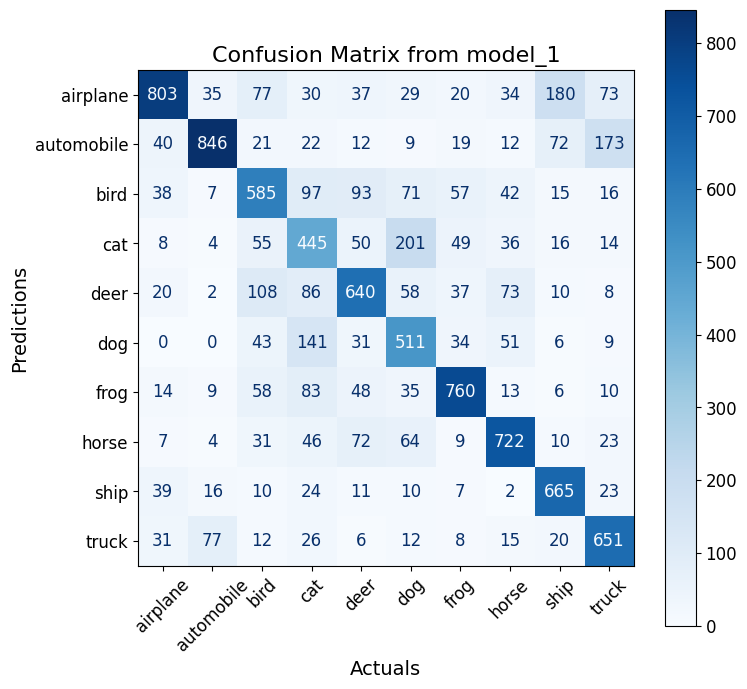

In [22]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [23]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.61      0.80      0.69      1000
  automobile       0.69      0.85      0.76      1000
        bird       0.57      0.58      0.58      1000
         cat       0.51      0.45      0.47      1000
        deer       0.61      0.64      0.63      1000
         dog       0.62      0.51      0.56      1000
        frog       0.73      0.76      0.75      1000
       horse       0.73      0.72      0.73      1000
        ship       0.82      0.67      0.74      1000
       truck       0.76      0.65      0.70      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000



$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
Precision &= \frac{TP}{TP + FP} \\
Recall &= \frac{TP}{TP + FN} \\
F1-Score &= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{align}
$

where 
$TP$: True Positives, $TN$: True Negatives, $FP$: False Positives, and $FN$: False Negatives


### <span style="color:blue">แบบฝึกปฏิบัติ</span>
จากโครงสร้างของโมเดลเดิม:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. ให้สร้างโมเดลใหม่ที่มีความซับซ้อนมากขึ้นโดยสามารถใช้รูปแบบโครงสร้างดังนี้:
   - Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

   - ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional.

2. เทรนโมเดลใหม่โดยใช้เพียง 10 epochs (เท่ากับการเทรนโมเดลเดิม) และอธิบายสิ่งที่สังเกตได้ในเรื่องของเวลา และค่า loss และ accuracy ที่วัดได้จากทั้งชุดข้อมูลเทรนและเทส

3. จากผลการทดสอบโมเดลใหม่ด้วยชุดข้อมูลเทส ให้สร้างกราฟ Confusion Matrix และแสดงรายงาน classification report

4. หาภาพที่โมเดลใหม่ทำนายผิดมาอย่างน้อย 1 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร

In [24]:
set_seed(12345)

model_2 = Sequential()

model_2.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', 
                   input_shape=x_train.shape[1:], activation='relu'))
model_2.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (5, 5), strides=(1, 1), 
                   padding='same', activation='relu'))
model_2.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
# model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes, activation='softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                 

In [34]:
batch_size = 32

opt = keras.optimizers.Adam(learning_rate=0.0005)

model_2.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_2 = model_2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 40s 25ms/step - loss: 0.4722 - accuracy: 0.8435 - val_loss: 0.8052 - val_accuracy: 0.7597
Epoch 2/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.3986 - accuracy: 0.8650 - val_loss: 0.8900 - val_accuracy: 0.7603
Epoch 3/10
1563/1563 [==============================] - 41s 26ms/step - loss: 0.3472 - accuracy: 0.8820 - val_loss: 0.8269 - val_accuracy: 0.7669
Epoch 4/10
1563/1563 [==============================] - 42s 27ms/step - loss: 0.3046 - accuracy: 0.8948 - val_loss: 0.8521 - val_accuracy: 0.7679
Epoch 5/10
1563/1563 [==============================] - 41s 26ms/step - loss: 0.2788 - accuracy: 0.9040 - val_loss: 0.8324 - val_accuracy: 0.7673
Epoch 6/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.2450 - accuracy: 0.9164 - val_loss: 0.9410 - val_accuracy: 0.7690
Epoch 7/10
1563/1563 [==============================] - 37s 24ms/step - loss: 0.2181 - accuracy: 0.9257 - val_loss: 1.2050 -

In [35]:
print("The loss on the test set is: ", model_1.evaluate(x_test, y_test)[0])
for i in range(len(history_1.history['loss'])):
    print("%d, %f\n" % (i+1, history_1.history['loss'][i]), end=' ')

  1/313 [..............................] - ETA: 6s - loss: 0.9395 - accuracy: 0.6562

313/313 [==============================] - 1s 2ms/step - loss: 1.0216 - accuracy: 0.6628
The loss on the test set is:  1.0215667486190796
1, 1.613767
 2, 1.292104
 3, 1.151970
 4, 1.050860
 5, 0.973706
 6, 0.903335
 7, 0.843643
 8, 0.786506
 9, 0.734284
 10, 0.687836
 

In [36]:
print("The accuracy on the test set is: ", model_1.evaluate(x_test, y_test)[1])
for i in range(len(history_1.history['accuracy'])):
    print("%d, %f\n" % (i+1, history_1.history['accuracy'][i]), end=' ')

313/313 [==============================] - 1s 2ms/step - loss: 1.0216 - accuracy: 0.6628
The accuracy on the test set is:  0.6628000140190125
1, 0.420220
 2, 0.537900
 3, 0.594400
 4, 0.631740
 5, 0.659860
 6, 0.683780
 7, 0.705860
 8, 0.727140
 9, 0.745940
 10, 0.759220
 

In [37]:
for i in range(len(history_1.history['val_loss'])):
    print("%d, %f\n" % (i+1, history_1.history['val_loss'][i]), end=' ')

1, 1.481201
 2, 1.248333
 3, 1.140153
 4, 1.131717
 5, 1.092345
 6, 1.049319
 7, 1.033796
 8, 1.061393
 9, 0.996213
 10, 1.021567
 

In [38]:
for i in range(len(history_1.history['val_accuracy'])):
    print("%d, %f\n" % (i+1, history_1.history['val_accuracy'][i]), end=' ')

1, 0.475200
 2, 0.547100
 3, 0.591500
 4, 0.601800
 5, 0.621500
 6, 0.636600
 7, 0.644100
 8, 0.639600
 9, 0.659900
 10, 0.662800
 

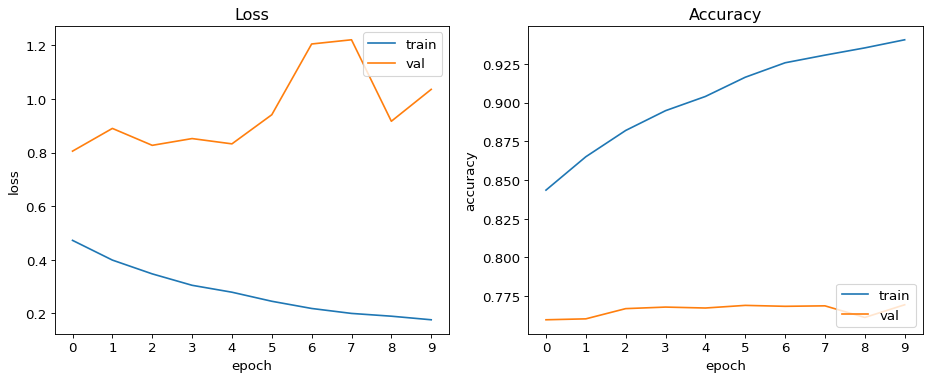

In [39]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_2.history['loss'])
ax.plot(history_2.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_2.history['accuracy'])
ax.plot(history_2.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [40]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_2.predict(x_test, verbose=0)

y_test_2d = np.argmax(y_test, axis=1)
y_pred_2d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_2d, y_pred=y_pred_2d).T
print(cm)

Train Loss: 0.112342, Accuracy: 0.965620
 Test Loss: 1.035685, Accuracy: 0.769400

[[794  17  65  13  12   6   7  12  55  38]
 [ 14 867   4   8   3   4   4   4  19  59]
 [ 42   2 648  56  62  45  28  19   7   4]
 [ 20   6  57 621  64 133  62  25  21  11]
 [ 19   5  66  65 738  36  28  61   9   8]
 [ 15   7  65 140  36 707  24  58   4   7]
 [ 10   8  50  46  42  22 827   9   6   6]
 [  8   0  21  31  38  34   6 799   6   7]
 [ 51  30  16  13   4   8  12   3 849  16]
 [ 27  58   8   7   1   5   2  10  24 844]]


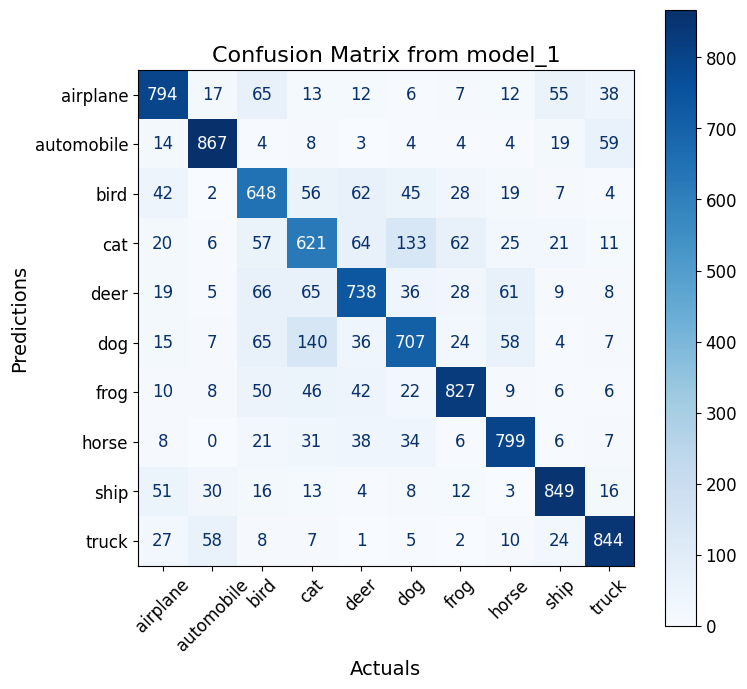

In [41]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [42]:
np.set_printoptions(precision=2)

'''
    Precision : ratio of correctly predicted positive 
                observations to the total predicted positives.
    Precision = TP / (TP + FP)
    
    Recall : ratio of correctly predicted 
             positive observations to the total actual positives.
    Recall = TP / (TP + FN)
    
    F1-score : harmonic mean of precision and recall,
               providing a balance between precision and recall.
    F1-score = 2 * (Precision * Recall) / (Precision + Recall)
    
    Support : number of actual occurrences of the class in the specified dataset.
'''

print(classification_report(y_true=y_test_2d, y_pred=y_pred_2d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.78      0.79      0.79      1000
  automobile       0.88      0.87      0.87      1000
        bird       0.71      0.65      0.68      1000
         cat       0.61      0.62      0.61      1000
        deer       0.71      0.74      0.73      1000
         dog       0.67      0.71      0.69      1000
        frog       0.81      0.83      0.82      1000
       horse       0.84      0.80      0.82      1000
        ship       0.85      0.85      0.85      1000
       truck       0.86      0.84      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

